In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from sp_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core/p5-240826-091418/Notes.txt
read from t=0s to t=790.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core/nn2-250117-085631/Notes.txt
read from t=0s to t=814.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core/p2-240523-081105/Notes.txt
read from t=0s to t=788.65s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core/nn4-250118-094351/Notes.txt
read from t=0s to t=795.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_no_core/nn1-250117-081652/Notes.txt
read from t=0s to t=870.75s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all

In [4]:
bout_definitions = [
    {'prefix': 'Subject', 'introduced': 'Subject Introduced', 'removed': 'Subject Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=False)

Processing behaviors for p5-240826-091418...
Processing behaviors for nn2-250117-085631...
Processing behaviors for p2-240523-081105...
Processing behaviors for nn4-250118-094351...
Processing behaviors for nn1-250117-081652...
Processing behaviors for pp7-250118-075659...
Processing behaviors for pp3-250118-064713...
Processing behaviors for p8-240827-075823...
Processing behaviors for nn8-250118-105443...
Processing behaviors for p1-240522-080200...
Processing behaviors for p6-240827-065303...
Processing behaviors for pp5-250117-121543...
Processing behaviors for pp4-250118-072201...
Processing behaviors for nn7-250118-101917...
Processing behaviors for pp8-250118-083250...
Processing behaviors for nn6-250117-101903...
Processing behaviors for p7-240826-102402...
Processing behaviors for pp6-250117-124823...
Processing behaviors for p3-240522-092431...
Processing behaviors for nn3-250118-090940...
Processing behaviors for nn5-250117-093631...
Processing behaviors for p4-240523-092600

## Long-Term Bar Graph - Total Investigation Time

In [5]:
def fix_behavior_data_for_experiment(experiment, csv_base_path):
    """
    Loads and converts raw CSVs into behavior DataFrames for each trial in the experiment.
    Replaces experiment.trials[trial_name].behaviors with the corrected DataFrame.
    """
    fixed_trials = 0
    skipped_trials = 0

    for trial_name in experiment.trials:
        csv_file = os.path.join(csv_base_path, trial_name + ".csv")

        if not os.path.exists(csv_file):
            print(f"CSV not found for trial '{trial_name}' — skipped.")
            skipped_trials += 1
            continue

        try:
            raw_df = pd.read_csv(csv_file)

            # Only process rows that have Start, Stop, Duration
            if {"Start (s)", "Stop (s)", "Duration (s)", "Behavior"}.issubset(raw_df.columns):
                behavior_df = pd.DataFrame({
                    "Behavior": raw_df["Behavior"],
                    "Event_Start": raw_df["Start (s)"],
                    "Event_End": raw_df["Stop (s)"],
                    "Duration (s)": raw_df["Duration (s)"],
                    "Bout": raw_df.get("Subject", "Subject-1")  # fallback if no 'Subject'
                })

                # Clean up NaNs, e.g., missing durations
                behavior_df.dropna(subset=["Event_Start", "Event_End", "Duration (s)"], inplace=True)

                # Inject into experiment object
                experiment.trials[trial_name].behaviors = behavior_df.reset_index(drop=True)
                fixed_trials += 1
            else:
                print(f"CSV for trial '{trial_name}' missing required columns — skipped.")
                skipped_trials += 1

        except Exception as e:
            print(f"Error processing trial '{trial_name}': {e}")
            skipped_trials += 1

    print(f"\nFinished processing CSVs.")
    print(f"Fixed trials: {fixed_trials}")
    print(f"Skipped trials: {skipped_trials}")
    

In [6]:
def plot_custom_sniff_cup_assignments(experiment, 
                                      assignment_csv_path,
                                      bar_color='#cccccc', 
                                      figsize=(6, 8),
                                      title="Mean Investigation Time (Long Term Sniff Cups)",
                                      pad_inches=0.1,
                                      save=False,
                                      save_name=None):
    """
    For each subject, extracts total investigation time for the sniff cup assigned to 'long_term',
    classifies them as Pref or No_Pref, and plots the mean + individual data points.

    Returns:
    - DataFrame with 'Preference' column
    - Prints lists of Pref and No_Pref subjects
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # --- Load assignment CSV ---
    assign_df = pd.read_csv(assignment_csv_path)

    # --- Build subject -> sniff cup (assigned to long_term) mapping ---
    subject_to_behavior = {}

    for idx, row in assign_df.iterrows():
        subject = str(row['Subject']).strip()
        for cup_col in assign_df.columns:
            if 'sniff cup' in cup_col.lower():
                cup_value = str(row[cup_col]).strip().lower()
                if cup_value == 'long_term':
                    subject_to_behavior[subject] = cup_col.lower()
                    break  # Stop at first match for long_term

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key]

            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Subject": trial_name,
                "Total Investigation Time": total_time,
                "Assigned Behavior": target_behavior
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for sniff cup assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    # --- Classification ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()
    threshold = mean_time + sem_time

    data_df["Preference"] = data_df["Total Investigation Time"].apply(
        lambda t: "Pref" if t > threshold else "No_Pref"
    )

    # Store subjects by classification
    pref_subjects = data_df[data_df["Preference"] == "Pref"]["Subject"].tolist()
    no_pref_subjects = data_df[data_df["Preference"] == "No_Pref"]["Subject"].tolist()

    print(f"\nPref Subjects ({len(pref_subjects)}): {pref_subjects}")
    print(f"No_Pref Subjects ({len(no_pref_subjects)}): {no_pref_subjects}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color, edgecolor='black', linewidth=3, width=0.6)

    for _, row in data_df.iterrows():
        subj = row["Subject"]
        time = row["Total Investigation Time"]

        color = "#15616F" if subj.lower().startswith('n') else "#FFAF00" if subj.lower().startswith('p') else "gray"
        ax.plot(0, time, 'o', color=color, markersize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(["Long Term Sniff Cup"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    
    plt.show()

    return data_df, pref_subjects, no_pref_subjects



Finished processing CSVs.
Fixed trials: 24
Skipped trials: 0

Total trials: 24
Valid trials with matched behavior: 24
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0

Pref Subjects (7): ['p5-240826-091418', 'pp3-250118-064713', 'pp5-250117-121543', 'pp4-250118-072201', 'p7-240826-102402', 'nn3-250118-090940', 'p4-240523-092600']
No_Pref Subjects (17): ['nn2-250117-085631', 'p2-240523-081105', 'nn4-250118-094351', 'nn1-250117-081652', 'pp7-250118-075659', 'p8-240827-075823', 'nn8-250118-105443', 'p1-240522-080200', 'p6-240827-065303', 'nn7-250118-101917', 'pp8-250118-083250', 'nn6-250117-101903', 'pp6-250117-124823', 'p3-240522-092431', 'nn5-250117-093631', 'pp1-250117-110456', 'pp2-250117-113909']


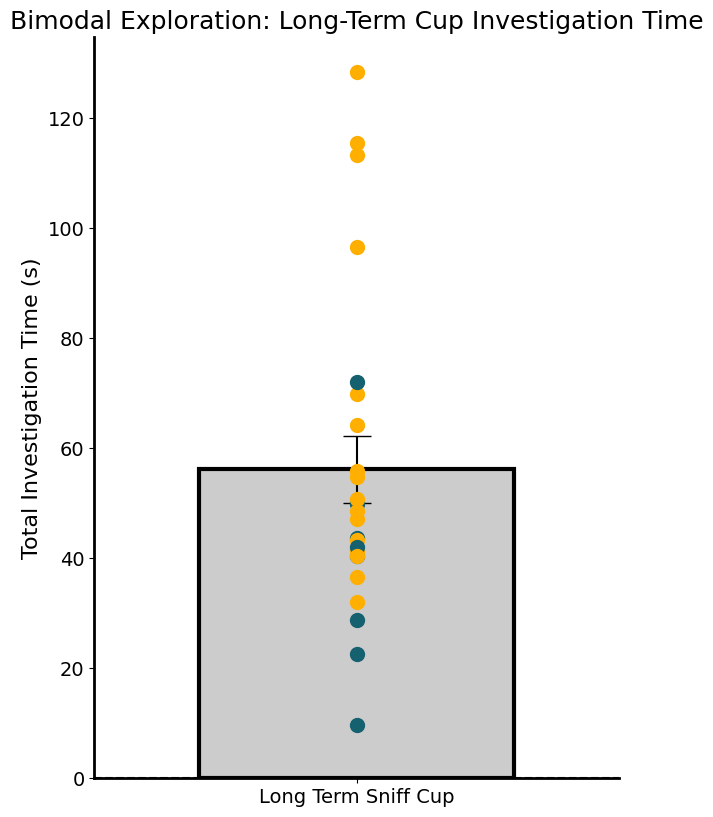

Subjects Pref: ['p5-240826-091418', 'pp3-250118-064713', 'pp5-250117-121543', 'pp4-250118-072201', 'p7-240826-102402', 'nn3-250118-090940', 'p4-240523-092600']
Subjects No_Pref: ['nn2-250117-085631', 'p2-240523-081105', 'nn4-250118-094351', 'nn1-250117-081652', 'pp7-250118-075659', 'p8-240827-075823', 'nn8-250118-105443', 'p1-240522-080200', 'p6-240827-065303', 'nn7-250118-101917', 'pp8-250118-083250', 'nn6-250117-101903', 'pp6-250117-124823', 'p3-240522-092431', 'nn5-250117-093631', 'pp1-250117-110456', 'pp2-250117-113909']


In [7]:
cups = "/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/Social_Pref_Cup_Assignments.csv"

# Run this before plotting
fix_behavior_data_for_experiment(experiment, csv_base_path)

# Now all experiment.trials[...].behaviors are valid — plot will work!
df_with_pref, pref_list, no_pref_list = plot_custom_sniff_cup_assignments(
    experiment=experiment,
    assignment_csv_path=cups,  # Replace with actual path
    bar_color='#cccccc',
    figsize=(6, 8),
    pad_inches=0.1,
    title="Bimodal Exploration: Long-Term Cup Investigation Time",
    save=False,
    save_name="LongTerm_BarGraph.png"
)

# View results
print("Subjects Pref:", pref_list)
print("Subjects No_Pref:", no_pref_list)

### With colors

In [117]:
def plot_grouped_sniff_cup_assignments(experiment, 
                                       assignment_csv_path,
                                       bar_color='#cccccc', 
                                       color_nn_pp="red", 
                                       color_n_p="blue", 
                                       figsize=(6, 8),
                                       title="Grouped Mean Investigation Time (Long Term Sniff Cups)",
                                       pad_inches=0.1,
                                       save=False,
                                       save_name=None):
    """
    Groups subjects by prefix:
      - nn/pp → one color
      - n/p → another color
    Dynamically extracts sniff cup assigned to 'long_term' from CSV,
    and plots their investigation times with group colors and a legend.

    Parameters:
    - assignment_csv_path (str): Path to CSV with Subject + sniff cup assignments.
    - title (str): Title for the plot.
    """
    # --- Load assignment CSV ---
    assign_df = pd.read_csv(assignment_csv_path)

    # --- Map subject → sniff cup assigned to long_term ---
    subject_to_behavior = {}

    for idx, row in assign_df.iterrows():
        subject = str(row['Subject']).strip()
        for col in assign_df.columns:
            if 'sniff cup' in col.lower():
                value = str(row[col]).strip().lower()
                if value == 'long_term':
                    subject_to_behavior[subject] = col.lower()
                    break

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key]

            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            # Group by subject type
            if matched_key.lower().startswith(("nn", "pp")):
                color = color_nn_pp
                group_label = "nn / pp"
            else:
                color = color_n_p
                group_label = "n / p"

            subject_data.append({
                "Trial": trial_name,
                "Group": group_label,
                "Total Investigation Time": total_time,
                "Color": color
            })
            valid_trials += 1
        else:
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for sniff cup assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(["Long Term Sniff Cup"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # --- Legend ---
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_n_p,
                   markersize=10, label="Cohort 1 + 2"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_nn_pp,
                   markersize=10, label="Cohort 3")
    ]
    ax.legend(handles=legend_elements, title="Groups", loc='upper left', fontsize=10, title_fontsize=12)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()




Total trials: 24
Valid trials with matched behavior: 24
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 24


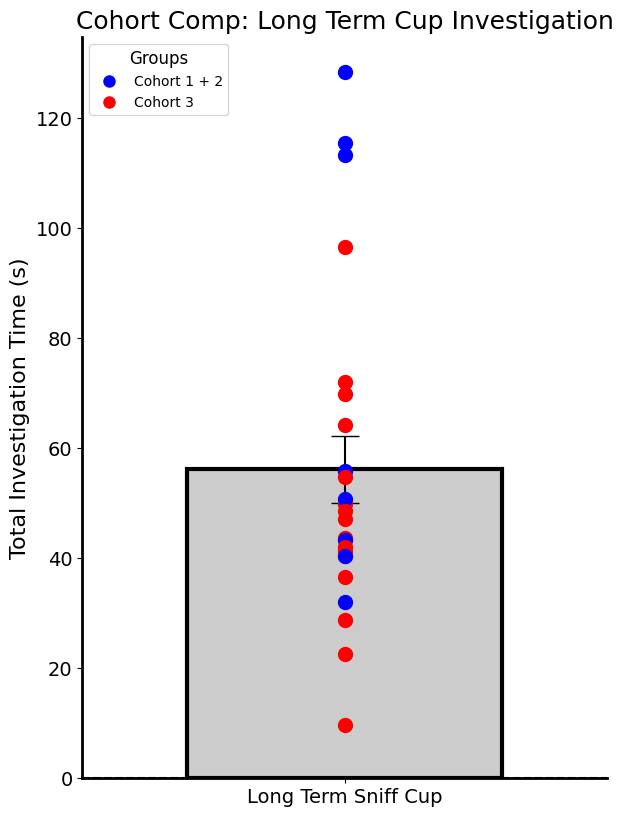

In [118]:
plot_grouped_sniff_cup_assignments(
    experiment=experiment,
    assignment_csv_path=cups,
    bar_color='#cccccc',
    color_nn_pp='red',
    color_n_p='blue',
    figsize=(6, 8),
    title="Cohort Comp: Long Term Cup Investigation",
    pad_inches=0.1,
    save=False,
    save_name="CohortComp_LT_IT.png"
)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_custom_sniff_cup_assignments_with_legend(experiment, bar_color='#cccccc', figsize=(12, 8)):
    """
    For each subject, extracts total investigation time for a pre-assigned 'sniff cup X' behavior,
    plots individual data in a unique color per subject, and adds a legend mapping subject → color.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3",
        "P1": "sniff cup 4",
        "N2": "sniff cup 1",
        "P3": "sniff cup 2",
        "N3": "sniff cup 2",
        "P2": "sniff cup 1",
        "N4": "sniff cup 4",
        "P4": "sniff cup 3",
        "N5": "sniff cup 3",
        "P5": "sniff cup 4",
        "N6": "sniff cup 1",
        "P7": "sniff cup 2",
        "P6": "sniff cup 1",
        "N7": "sniff cup 2",
        "P8": "sniff cup 3",
        "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1",
        "Nn5": "sniff cup 2",
        "Nn6": "sniff cup 3",
        "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1",
        "Pp5": "sniff cup 2",
        "Pp6": "sniff cup 3",
        "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3",
        "Pp7": "sniff cup 4",
        "Pp8": "sniff cup 1",
        "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3",
        "Nn7": "sniff cup 4",
        "Nn8": "sniff cup 1"
    }

    # --- Unique color for each subject ---
    subject_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#393b79", "#637939",
        "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#9c9ede", "#cedb9c",
        "#bd9e39", "#d6616b", "#e7969c", "#a55194", "#de9ed6", "#6b6ecf",
        "#9c9ede", "#637939", "#e7ba52", "#e7969c", "#843c39", "#8c6d31", "#7b4173"
    ]

    subject_to_color = dict(zip(subject_to_behavior.keys(), subject_colors))

    # --- Data collection ---
    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Trial": trial_name,
                "Subject Key": matched_key,
                "Total Investigation Time": total_time,
                "Color": subject_to_color[matched_key]
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points with unique colors
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Set labels and title
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time per Subject (Custom Cups)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    # Beautify plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # --- Legend ---
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=subject_to_color[key],
                   markersize=10, label=key)
        for key in subject_to_behavior.keys()
    ]

    ax.legend(handles=legend_elements, title="Subjects", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12, borderaxespad=0.)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


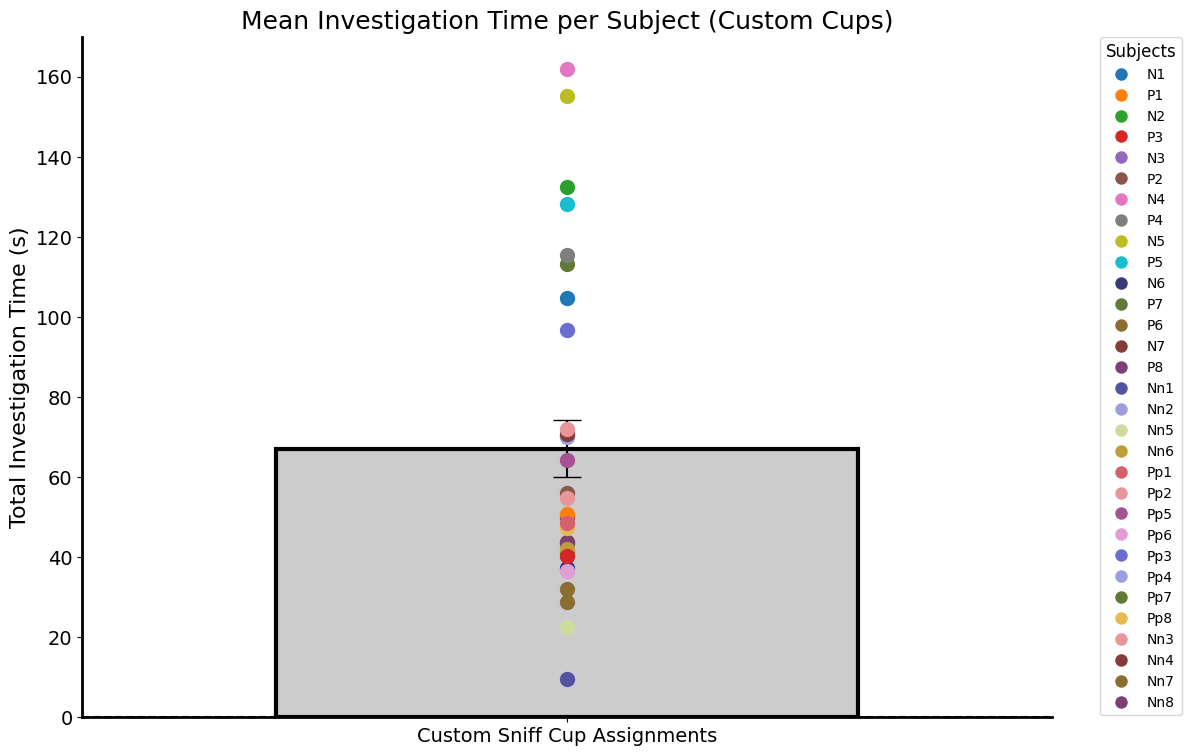

In [13]:
plot_custom_sniff_cup_assignments_with_legend(experiment)

## Bimodal Behavior

In [13]:
def create_metadata_dataframe(trial_data, behavior="Investigation", desired_bouts=None):
    """
    Computes total investigation time (sum of durations) and
    average bout duration (total / number of events) per subject × bout.
    Ensures zero-filled rows for missing subject-bout combinations.
    """
    combined_rows = []

    # Combine all subject DataFrames into one
    for subject_id, df in trial_data.items():
        df_copy = df.copy()
        df_copy["Subject"] = subject_id
        combined_rows.append(df_copy)

    combined_df = pd.concat(combined_rows, ignore_index=True)

    # Filter by behavior
    df_behavior = combined_df[combined_df["Behavior"] == behavior].copy()
    if df_behavior.empty:
        print(f"No events found for behavior='{behavior}'.")
        return pd.DataFrame(columns=["Subject", "Bout", "Behavior", "Total Investigation Time", "Average Bout Duration"])

    # Determine all subjects and bouts
    all_subjects = sorted(combined_df["Subject"].unique())
    all_bouts = desired_bouts if desired_bouts else sorted(df_behavior["Bout"].unique())

    # --- Group by Subject × Bout: sum durations, count events ---
    grouped = df_behavior.groupby(["Subject", "Bout"])["Duration (s)"].agg(
        Total_Investigation_Time="sum",
        Event_Count="count"
    ).reset_index()

    # Create full grid (Subject × Bout) for merging
    full_grid = pd.MultiIndex.from_product([all_subjects, all_bouts], names=["Subject", "Bout"]).to_frame(index=False)

    # Merge with actual data, filling missing values with 0
    merged = pd.merge(full_grid, grouped, on=["Subject", "Bout"], how="left").fillna(0)

    # Compute average bout duration: total / count (handle division by zero safely)
    merged["Average_Bout_Duration"] = merged.apply(
        lambda row: row["Total_Investigation_Time"] / row["Event_Count"] if row["Event_Count"] > 0 else 0, axis=1
    )

    # Add behavior column
    merged["Behavior"] = behavior

    # Select and rename columns
    final_df = merged[["Subject", "Bout", "Behavior", "Total_Investigation_Time", "Average_Bout_Duration"]].rename(
        columns={
            "Total_Investigation_Time": "Total Investigation Time",
            "Average_Bout_Duration": "Average Bout Duration"
        }
    )

    return final_df


def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a dictionary where:
    - Keys are subject IDs (Trial.subject_name).
    - Values are DataFrames corresponding to the behaviors of each trial.
    """
    trial_data = {}

    for trial in experiment.trials.values():
        subject_id = trial.subject_name  # Extract subject ID
        trial_data[subject_id] = trial.behaviors  # Store behaviors DataFrame

    return trial_data


# Step 1: Get trial data
trial_data = get_trial_dataframes(experiment)


# Step 3: Create metadata dataframe with trimmed data
metadata_df = create_metadata_dataframe(trial_data, behavior="Investigation")
metadata_df



No events found for behavior='Investigation'.


,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration


In [12]:
def get_trial_dataframes_with_ids(experiment):
    """
    Given an Experiment object, return a list of (subject_id, DataFrame) tuples,
    where each DataFrame corresponds to the .behaviors of each trial.
    The subject_id is extracted from the trial name.
    """
    trial_dataframes = []

    for trial_id, trial in experiment.trials.items():
        # Extract subject ID (e.g., 'n1', 'pp3') from the trial name
        subject_id = trial_id.split('-')[0].lower()  # Convert to lowercase for consistency
        df = trial.behaviors

        # Only include if behaviors exist and are not empty
        if df is not None and not df.empty:
            trial_dataframes.append((subject_id, df.copy()))
        else:
            print(f"Skipping {trial_id}: no behavior data.")

    return trial_dataframes

dfs_with_ids = get_trial_dataframes_with_ids(experiment)
dfs_with_ids

[('p5',
         Behavior  Event_Start  Event_End  Duration (s)     Bout
  0   sniff cup 2        189.4      196.4           7.0  Subject
  1   sniff cup 2        198.6      200.8           2.2  Subject
  2   sniff cup 4        203.5      205.0           1.5  Subject
  3   sniff cup 4        206.4      207.3           0.9  Subject
  4   sniff cup 3        208.6      210.2           1.6  Subject
  5   sniff cup 1        211.9      218.2           6.3  Subject
  6   sniff cup 3        219.9      226.8           6.9  Subject
  7   sniff cup 4        231.4      243.4          12.0  Subject
  8   sniff cup 2        246.4      249.1           2.7  Subject
  9   sniff cup 3        259.2      259.7           0.5  Subject
  10  sniff cup 4        262.2      264.2           2.0  Subject
  11  sniff cup 4        265.9      271.5           5.6  Subject
  12  sniff cup 4        272.3      280.0           7.7  Subject
  13  sniff cup 2        284.4      286.7           2.3  Subject
  14  sniff cup 4

In [9]:
def compute_agent_metrics_from_sniff_cup_csv(dfs_with_ids, sniff_cup_csv_path):
    """
    For each subject, maps sniff cup behaviors to agents (long_term, short_term, etc.),
    and computes:
      - Total Investigation Time
      - Average Bout Duration
    for each agent per subject.

    Parameters:
    - dfs_with_ids: List of (subject_id, DataFrame) pairs.
    - sniff_cup_csv_path: Path to CSV that maps sniff cup X to agent per subject.

    Returns:
    - DataFrame with subjects as rows, columns for Total/Avg per agent.
    """
    # --- Load mapping CSV ---
    cup_map_df = pd.read_csv(sniff_cup_csv_path)
    cup_map_df['Subject'] = cup_map_df['Subject'].str.lower()

    results = []

    for subj_id, df in dfs_with_ids:
        subj_id_lower = subj_id.lower()

        # Find mapping row for this subject
        row_match = cup_map_df[cup_map_df['Subject'] == subj_id_lower]
        if row_match.empty:
            print(f"⚠️ No mapping found for subject '{subj_id}'. Skipping.")
            continue

        mapping = row_match.iloc[0]

        # Build sniff cup X → agent map for this subject
        sniff_to_agent = {}
        for col in mapping.index:
            if "sniff cup" in col.lower():
                cup = col.lower()
                agent = str(mapping[col]).strip().lower()
                sniff_to_agent[cup] = agent

        # Filter behaviors to sniff cups only, map to agents
        df_filtered = df[df["Behavior"].str.lower().str.startswith("sniff cup")].copy()
        df_filtered["Behavior"] = df_filtered["Behavior"].str.lower()
        df_filtered["Agent"] = df_filtered["Behavior"].map(sniff_to_agent)

        df_filtered = df_filtered[df_filtered["Agent"].notnull()]  # Remove rows with no agent match
        if df_filtered.empty:
            print(f"⚠️ Subject '{subj_id}' has no valid sniff cup mappings. Skipping.")
            continue

        # --- Compute Total + Avg per agent ---
        group = df_filtered.groupby("Agent")
        row_data = {"Subject": subj_id}

        for agent_name, agent_df in group:
            total_time = agent_df["Duration (s)"].sum()
            bout_count = agent_df["Bout"].nunique()
            avg_bout = total_time / bout_count if bout_count > 0 else 0

            row_data[f"Total_{agent_name}"] = total_time
            row_data[f"Avg_{agent_name}"] = avg_bout

        results.append(row_data)

    final_df = pd.DataFrame(results).set_index("Subject").fillna(0)
    return final_df


dfs_with_ids = get_trial_dataframes_with_ids(experiment)
result_df = compute_agent_metrics_from_sniff_cup_csv(
    dfs_with_ids=dfs_with_ids,
    sniff_cup_csv_path=cups
)

# View result
display(result_df)


,Total_long_term,Avg_long_term,Total_nothing,Avg_nothing,Total_novel,Avg_novel,Total_short_term,Avg_short_term
Subject,,,,,,,,
p5,128.300,128.300,42.700,42.700,48.500,48.500,51.600,51.600
nn2,40.400,40.400,49.900,49.900,81.199,81.199,75.699,75.699
p2,55.932,55.932,98.998,98.998,79.063,79.063,54.731,54.731
nn4,43.700,43.700,60.900,60.900,84.500,84.500,36.900,36.900
nn1,9.600,9.600,93.000,93.000,55.998,55.998,35.100,35.100
pp7,41.300,41.300,61.400,61.400,104.899,104.899,57.500,57.500
pp3,96.600,96.600,50.700,50.700,27.300,27.300,15.600,15.600
p8,43.400,43.400,88.899,88.899,65.100,65.100,71.400,71.400
nn8,49.900,49.900,38.900,38.900,56.800,56.800,90.100,90.100


In [11]:
import pandas as pd

def compute_agent_investigation_metrics(dfs_with_ids, sniff_cup_csv_path):
    """
    Corrected version: computes Total Investigation Time and Average Bout Duration
    for each agent per subject. Ensures no duplicate columns.

    Parameters:
    - dfs_with_ids: List of (subject_id, DataFrame) pairs.
    - sniff_cup_csv_path: Path to sniff cup assignment CSV.

    Returns:
    - DataFrame: Rows = subjects, Columns = Total_ / Avg_ per agent
    """
    # --- Load and normalize mapping CSV ---
    cup_map_df = pd.read_csv(sniff_cup_csv_path)
    cup_map_df['Subject'] = cup_map_df['Subject'].str.lower()

    results = []

    for subj_id, df in dfs_with_ids:
        subj_id_lower = subj_id.lower()
        mapping_row = cup_map_df[cup_map_df['Subject'] == subj_id_lower]
        if mapping_row.empty:
            print(f"⚠️ No mapping for {subj_id}. Skipping.")
            continue

        mapping = mapping_row.iloc[0]

        # Sniff cup to agent mapping
        sniff_to_agent = {}
        for col in mapping.index:
            if "sniff cup" in col.lower():
                cup = col.lower()
                agent = str(mapping[col]).strip().lower()
                sniff_to_agent[cup] = agent

        # Filter for sniff cups and map to agent
        df_filtered = df[df["Behavior"].str.lower().str.startswith("sniff cup")].copy()
        df_filtered["Behavior"] = df_filtered["Behavior"].str.lower()
        df_filtered["Agent"] = df_filtered["Behavior"].map(sniff_to_agent)

        df_filtered = df_filtered[df_filtered["Agent"].notnull()]
        if df_filtered.empty:
            print(f"⚠️ {subj_id} has no valid sniff cup mappings. Skipping.")
            continue

        # --- Group by Agent, calculate total time and avg bout duration ---
        group = df_filtered.groupby("Agent")
        row_data = {"Subject": subj_id}

        for agent_name, agent_df in group:
            total_time = agent_df["Duration (s)"].sum()
            bout_count = agent_df["Bout"].nunique()
            avg_bout = total_time / bout_count if bout_count > 0 else 0

            row_data[f"Total_{agent_name}"] = round(total_time, 3)
            row_data[f"Avg_{agent_name}"] = round(avg_bout, 3)

        results.append(row_data)

    # --- Combine all results safely ---
    final_df = pd.DataFrame(results).set_index("Subject").fillna(0)

    # Remove duplicate columns (if any)
    final_df = final_df.loc[:, ~final_df.columns.duplicated()]

    return final_df

# Path to your CSV or Excel file
agent_map_path = cups

# Prepare dfs_with_ids: list of (subject_id, DataFrame) from get_trial_dataframes_with_ids()
dfs_with_ids = get_trial_dataframes_with_ids(experiment)

# Call the function
result_df = compute_agent_investigation_metrics(dfs_with_ids, agent_map_path)

# View result
result_df

,Total_long_term,Avg_long_term,Total_nothing,Avg_nothing,Total_novel,Avg_novel,Total_short_term,Avg_short_term
Subject,,,,,,,,
p5,128.300,128.300,42.700,42.700,48.500,48.500,51.600,51.600
nn2,40.400,40.400,49.900,49.900,81.199,81.199,75.699,75.699
p2,55.932,55.932,98.998,98.998,79.063,79.063,54.731,54.731
nn4,43.700,43.700,60.900,60.900,84.500,84.500,36.900,36.900
nn1,9.600,9.600,93.000,93.000,55.998,55.998,35.100,35.100
pp7,41.300,41.300,61.400,61.400,104.899,104.899,57.500,57.500
pp3,96.600,96.600,50.700,50.700,27.300,27.300,15.600,15.600
p8,43.400,43.400,88.899,88.899,65.100,65.100,71.400,71.400
nn8,49.900,49.900,38.900,38.900,56.800,56.800,90.100,90.100


In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

def plot_investigation_by_agent(df,
                                 subjects_to_include=None,
                                 metric="Total",  # "Total" or "Avg"
                                 title='Investigation Time by Agent',
                                 ylabel='Investigation Time (s)',
                                 xlabel='Agent',
                                 custom_xtick_labels=None,
                                 custom_xtick_colors=None,
                                 ylim=None,
                                 bar_fill_color='white',
                                 bar_edge_color='black',
                                 bar_linewidth=3,
                                 bar_hatch='///',
                                 yticks_increment=None,
                                 figsize=(12, 7),
                                 pad_inches=0.1,
                                 save=False,
                                 save_name=None):
    """
    Plots investigation time (Total or Avg) across agents: nothing, short_term, long_term, novel.

    Parameters:
        - df (DataFrame): Includes subject-wise columns for Total/Avg per agent.
        - subjects_to_include (list or None): Filter to only these subjects (e.g., pref_list).
        - metric (str): 'Total' or 'Avg' to choose which metric to plot.
    """
    df = df.copy()

    # --- Ensure Subject column exists ---
    if 'Subject' not in df.columns:
        df.reset_index(inplace=True)
    df['Subject'] = df['Subject'].astype(str)
    df.set_index('Subject', inplace=True)

    # --- Filter by subjects ---
    if subjects_to_include:
        subjects_to_include = [s.lower() for s in subjects_to_include]
        df = df[df.index.str.lower().isin(subjects_to_include)]

    # --- Column Order ---
    agents = ['nothing', 'short_term', 'long_term', 'novel']
    columns_to_plot = [f"{metric}_{agent}" for agent in agents]

    # --- Check for missing columns ---
    missing_cols = [col for col in columns_to_plot if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return

    # --- Prepare data ---
    df_plot = df[columns_to_plot].copy()
    df_plot.columns = agents  # Clean column names for plotting

    # --- Paired T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "nothing_vs_short_term": ("nothing", "short_term"),
            "nothing_vs_long_term": ("nothing", "long_term"),
            "nothing_vs_novel": ("nothing", "novel")
        }
        results = {}
        for key, (a1, a2) in comparisons.items():
            paired = df_vals[[a1, a2]].dropna()
            if len(paired) > 1:
                t_stat, p_value = ttest_rel(paired[a1], paired[a2])
                results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Mean & SEM ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()

    # --- Sanity Check: Ensure valid data ---
    if df_plot.isnull().all().all() or np.isnan(mean_vals).all():
        print("No valid data available to plot. Check your subjects_to_include and metric selection.")
        return

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Markers for Subjects ---
    for subject_id, row in df_plot.iterrows():
        prefix = subject_id.lower().strip()
        marker_color = '#15616F' if prefix.startswith('n') else '#FFAF00' if prefix.startswith('p') else 'gray'

        ax.plot(df_plot.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)
        ax.scatter(df_plot.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=24)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(df_plot.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df_plot.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "nothing_vs_short_term": (0, 1),
            "nothing_vs_long_term": (0, 2),
            "nothing_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    # --- Legend for Regions ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12)
    ]

    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    
    plt.show()


In [124]:
# Suppose df_metrics is your result DataFrame from compute_agent_investigation_metrics

# Plot for Pref subjects only:
plot_investigation_by_agent(df=result_df,
                            subjects_to_include=pref_list,
                            metric="Total",
                            title="Total Investigation Time (Long-Term Pref Mice)",
                            ylabel="Investigation Time (s)",
                            save=False,
                            save_name="pref_mice_investigation.png")

No valid data available to plot. Check your subjects_to_include and metric selection.


## Dopamine Stuff

In [63]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# calculate event induced
experiment.compute_all_event_induced_DA(pre_time=4, post_time=5)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

Processing behaviors for p5-240826-091418...
Processing behaviors for nn2-250117-085631...
Processing behaviors for p2-240523-081105...
Processing behaviors for nn4-250118-094351...
Processing behaviors for n6-240826-094701...
Processing behaviors for nn1-250117-081652...
Processing behaviors for pp7-250118-075659...
Processing behaviors for pp3-250118-064713...
Processing behaviors for p8-240827-075823...
Processing behaviors for nn8-250118-105443...
Processing behaviors for n3-240523-073132...
Processing behaviors for p1-240522-080200...
Processing behaviors for n5-240826-083822...
Processing behaviors for n4-240523-084829...
Processing behaviors for p6-240827-065303...
Processing behaviors for pp5-250117-121543...
Processing behaviors for pp4-250118-072201...
Processing behaviors for nn7-250118-101917...
Processing behaviors for pp8-250118-083250...
Processing behaviors for nn6-250117-101903...
Processing behaviors for p7-240826-102402...
Processing behaviors for pp6-250117-124823..

In [51]:
def create_event_zscore_dataframe_with_agent(experiment, agent_mapping_csv_path):
    """
    Extracts event-induced DA traces from all trials and assigns each with the appropriate agent
    based on sniff cup assignment from the CSV. Ensures 4 rows per subject (1 per sniff cup),
    with 0 filled for missing Event_Zscore data.

    Parameters:
    - experiment: Experiment object after compute_all_event_induced_DA()
    - agent_mapping_csv_path: File path to the subject × cup × agent mapping CSV

    Returns:
    - pd.DataFrame with columns: ['Subject', 'Behavior', 'Agent', 'Mean_Event_Zscore']
    """
    import pandas as pd
    import numpy as np

    # Load and preprocess CSV
    agent_map_df = pd.read_csv(agent_mapping_csv_path)
    agent_map_df['Subject'] = agent_map_df['Subject'].str.lower().str.strip()
    sniff_cup_cols = [col for col in agent_map_df.columns if col.lower().startswith('sniff')]

    # Prepare long-format: each subject × sniff cup × agent
    long_map = agent_map_df.melt(id_vars='Subject',
                                 value_vars=sniff_cup_cols,
                                 var_name='Behavior',
                                 value_name='Agent')
    long_map['Behavior'] = long_map['Behavior'].str.lower().str.strip()
    long_map['Agent'] = long_map['Agent'].str.lower().str.strip()

    # Build a lookup for event DA by (subject, behavior)
    event_lookup = {}
    for trial_name, trial in experiment.trials.items():
        subj_id = trial.subject_name.lower().strip()
        if trial.behaviors is None or 'Event_Zscore' not in trial.behaviors.columns:
            continue
        for _, row in trial.behaviors.iterrows():
            behavior_label = str(row['Behavior']).lower().strip()
            key = (subj_id, behavior_label)
            if key not in event_lookup:
                event_lookup[key] = []
            event_lookup[key].append(row['Event_Zscore'])

    # Final records: ensure 4 entries per subject (one per sniff cup)
    records = []
    for _, row in long_map.iterrows():
        subj_id = row['Subject']
        behavior = row['Behavior']
        agent = row['Agent']
        key = (subj_id, behavior)

        event_zscores = event_lookup.get(key, [0])  # Fill with 0 if missing
        for zscore_array in event_zscores:
            if isinstance(zscore_array, list) or isinstance(zscore_array, np.ndarray):
                mean_zscore = np.nanmean(zscore_array)
            else:
                mean_zscore = 0
            records.append({
                'Subject': subj_id,
                'Behavior': behavior,
                'Agent': agent,
                'Mean_Event_Zscore': mean_zscore
            })

    return pd.DataFrame(records)


In [71]:
agent_mapping_csv_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/Social_Pref_Cup_Assignments.csv"

event_zscore_df = create_event_zscore_dataframe_with_agent(experiment, agent_mapping_csv_path)

event_zscore_df

,Subject,Behavior,Agent,Mean_Event_Zscore
0,nn1,sniff cup 1,nothing,0.000000
1,nn2,sniff cup 1,long_term,0.000000
2,nn5,sniff cup 1,nothing,0.000000
3,nn6,sniff cup 1,novel,0.000000
4,pp1,sniff cup 1,nothing,0.000000
...,...,...,...,...
119,p3,sniff cup 4,novel,0.000000
120,n3,sniff cup 4,novel,0.000000
121,p2,sniff cup 4,nothing,-4.084643
122,n4,sniff cup 4,long_term,0.000000


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D
import pandas as pd

def plot_event_induced_da_by_agent(df,
                                   subjects_to_include=None,
                                   title='Event-Induced DA by Agent',
                                   ylabel='Mean DA Z-score',
                                   xlabel='Social Agent',
                                   custom_xtick_labels=None,
                                   custom_xtick_colors=None,
                                   ylim=None,
                                   bar_fill_color='white',
                                   bar_edge_color='black',
                                   bar_linewidth=3,
                                   bar_hatch='///',
                                   yticks_increment=None,
                                   figsize=(12, 7),
                                   pad_inches=0.1):
    """
    Plots per-subject mean event-induced DA (Mean_Event_Zscore) across agents: nothing, short_term, long_term, novel.

    Parameters:
        - df (DataFrame): Must have columns ['Subject', 'Agent', 'Mean_Event_Zscore'].
        - subjects_to_include (list): Optional list of subject IDs to filter.
    """

    df = df.copy()

    # --- Agent order enforcement ---
    agent_order = ['nothing', 'short_term', 'long_term', 'novel']
    df = df[df["Agent"].isin(agent_order)].copy()
    df["Agent"] = pd.Categorical(df["Agent"], categories=agent_order, ordered=True)

    # --- Filter subjects ---
    if subjects_to_include:
        subjects_to_include = [s.lower() for s in subjects_to_include]
        df = df[df["Subject"].str.lower().isin(subjects_to_include)]

    # --- Compute per-subject mean per agent ---
    subject_agent_means = df.groupby(["Subject", "Agent"], observed=True)["Mean_Event_Zscore"].mean().reset_index()
    pivot_df = subject_agent_means.pivot(index="Subject", columns="Agent", values="Mean_Event_Zscore").reindex(columns=agent_order)

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "nothing_vs_short_term": ("nothing", "short_term"),
            "nothing_vs_long_term": ("nothing", "long_term"),
            "nothing_vs_novel": ("nothing", "novel")
        }
        results = {}
        for key, (a1, a2) in comparisons.items():
            if a1 in df_vals.columns and a2 in df_vals.columns:
                paired = df_vals[[a1, a2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[a1], paired[a2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(pivot_df)

    # --- Stats ---
    mean_vals = pivot_df.mean()
    sem_vals = pivot_df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(pivot_df.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Grey lines and Subject Mean Dots ---
    for subject_id, row in pivot_df.iterrows():
        subject_prefix = str(subject_id).lower().strip()
        marker_color = '#15616F' if subject_prefix.startswith('n') else '#FFAF00' if subject_prefix.startswith('p') else 'gray'

        # Grey connecting line
        ax.plot(pivot_df.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored dots per agent
        ax.scatter(pivot_df.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=2)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([pivot_df.values.flatten(), mean_vals.values])
    min_val = np.nanmin(all_vals)
    max_val = np.nanmax(all_vals)
    if ylim is None:
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "nothing_vs_short_term": (0, 1),
            "nothing_vs_long_term": (0, 2),
            "nothing_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)

    plt.tight_layout(pad=pad_inches)
    plt.show()

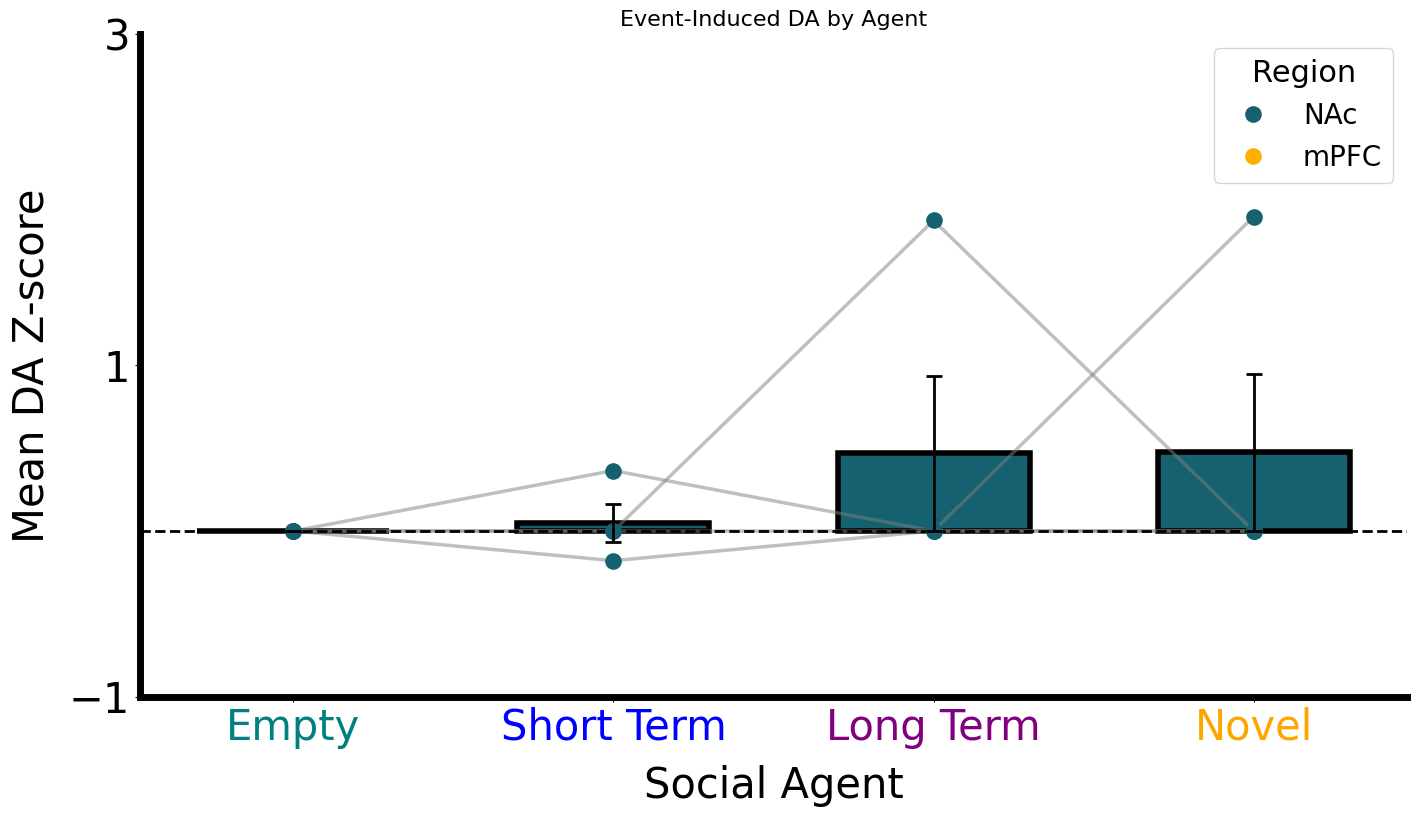

In [ ]:
# 'p5', 'p4', 'p7'pp3'

# Subjects you want to include
subjects_to_plot = ['n4', 'n5', 'n2', 'n1']

# Call the updated plotting function
plot_event_induced_da_by_agent(
    df=event_zscore_df,  # <- Your DataFrame with 'Subject', 'Agent', 'mean_zscore'
    subjects_to_include=subjects_to_plot,
    title="Event-Induced DA by Agent",
    ylabel="Mean DA Z-score",
    xlabel="Social Agent",
    custom_xtick_labels=["Empty", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 3),
    bar_fill_color='#15616F',
    bar_edge_color='black',
    bar_linewidth=4,
    bar_hatch=None,
    yticks_increment=2,
    figsize=(14, 8),
    pad_inches=0.1
)


# NAc: #15616F
# mPFC: #FFAF00

In [72]:
def create_event_zscore_dataframe_with_agent(experiment, agent_mapping_csv_path):
    """
    Extracts event-induced DA traces from all trials and assigns each with the appropriate agent
    based on sniff cup assignment from the CSV. Ensures 4 rows per subject (1 per sniff cup),
    with NaN filled for missing Event_Zscore data.

    Returns:
    - pd.DataFrame with columns: ['Subject', 'Behavior', 'Agent', 'Mean_Event_Zscore']
    """
    import pandas as pd
    import numpy as np

    agent_map_df = pd.read_csv(agent_mapping_csv_path)
    agent_map_df['Subject'] = agent_map_df['Subject'].str.lower().str.strip()
    sniff_cup_cols = [col for col in agent_map_df.columns if col.lower().startswith('sniff')]

    long_map = agent_map_df.melt(id_vars='Subject',
                                 value_vars=sniff_cup_cols,
                                 var_name='Behavior',
                                 value_name='Agent')
    long_map['Behavior'] = long_map['Behavior'].str.lower().str.strip()
    long_map['Agent'] = long_map['Agent'].str.lower().str.strip()

    event_lookup = {}
    for trial_name, trial in experiment.trials.items():
        subj_id = trial.subject_name.lower().strip()
        if trial.behaviors is None or 'Event_Zscore' not in trial.behaviors.columns:
            continue
        for _, row in trial.behaviors.iterrows():
            behavior_label = str(row['Behavior']).lower().strip()
            key = (subj_id, behavior_label)
            if key not in event_lookup:
                event_lookup[key] = []
            event_lookup[key].append(row['Event_Zscore'])

    records = []
    for _, row in long_map.iterrows():
        subj_id = row['Subject']
        behavior = row['Behavior']
        agent = row['Agent']
        key = (subj_id, behavior)

        if key in event_lookup:
            for zscore_array in event_lookup[key]:
                if isinstance(zscore_array, (list, np.ndarray)):
                    mean_zscore = np.nanmean(zscore_array)
                else:
                    mean_zscore = np.nan
                records.append({
                    'Subject': subj_id,
                    'Behavior': behavior,
                    'Agent': agent,
                    'Mean_Event_Zscore': mean_zscore
                })
        else:
            records.append({
                'Subject': subj_id,
                'Behavior': behavior,
                'Agent': agent,
                'Mean_Event_Zscore': np.nan
            })

    return pd.DataFrame(records)


def plot_event_induced_da_by_agent(df,
                                   subjects_to_include=None,
                                   title='Event-Induced DA by Agent',
                                   ylabel='Mean DA Z-score',
                                   xlabel='Social Agent',
                                   custom_xtick_labels=None,
                                   custom_xtick_colors=None,
                                   ylim=None,
                                   bar_fill_color='white',
                                   bar_edge_color='black',
                                   bar_linewidth=3,
                                   bar_hatch='///',
                                   yticks_increment=None,
                                   figsize=(12, 7),
                                   pad_inches=0.1):
    """
    Plots per-subject mean event-induced DA (Mean_Event_Zscore) across agents: nothing, short_term, long_term, novel.
    """
    df = df.copy()
    agent_order = ['nothing', 'short_term', 'long_term', 'novel']
    df = df[df["Agent"].isin(agent_order)].copy()
    df["Agent"] = pd.Categorical(df["Agent"], categories=agent_order, ordered=True)

    if subjects_to_include:
        subjects_to_include = [s.lower() for s in subjects_to_include]
        df = df[df["Subject"].str.lower().isin(subjects_to_include)]

    subject_agent_means = df.groupby(["Subject", "Agent"], observed=True)["Mean_Event_Zscore"].mean().reset_index()
    pivot_df = subject_agent_means.pivot(index="Subject", columns="Agent", values="Mean_Event_Zscore").reindex(columns=agent_order)

    def perform_t_tests(df_vals):
        comparisons = {
            "nothing_vs_short_term": ("nothing", "short_term"),
            "nothing_vs_long_term": ("nothing", "long_term"),
            "nothing_vs_novel": ("nothing", "novel")
        }
        results = {}
        for key, (a1, a2) in comparisons.items():
            paired = df_vals[[a1, a2]].dropna()
            if len(paired) > 1:
                t_stat, p_value = ttest_rel(paired[a1], paired[a2])
                results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(pivot_df)
    mean_vals = pivot_df.mean()
    sem_vals = pivot_df.sem()

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(pivot_df.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    for subject_id, row in pivot_df.iterrows():
        subject_prefix = str(subject_id).lower().strip()
        marker_color = '#15616F' if subject_prefix.startswith('n') else '#FFAF00' if subject_prefix.startswith('p') else 'gray'

        ax.plot(pivot_df.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)
        ax.scatter(pivot_df.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=2)

    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    all_vals = np.concatenate([pivot_df.values.flatten(), mean_vals.values])
    min_val = np.nanmin(all_vals)
    max_val = np.nanmax(all_vals)
    if ylim is None:
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "nothing_vs_short_term": (0, 1),
            "nothing_vs_long_term": (0, 2),
            "nothing_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)

    plt.tight_layout(pad=pad_inches)
    plt.show()


In [73]:
agent_mapping_csv_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/Social_Pref_Cup_Assignments.csv"

event_zscore_df = create_event_zscore_dataframe_with_agent(experiment, agent_mapping_csv_path)

event_zscore_df

,Subject,Behavior,Agent,Mean_Event_Zscore
0,nn1,sniff cup 1,nothing,NaN
1,nn2,sniff cup 1,long_term,NaN
2,nn5,sniff cup 1,nothing,NaN
3,nn6,sniff cup 1,novel,NaN
4,pp1,sniff cup 1,nothing,NaN
...,...,...,...,...
119,p3,sniff cup 4,novel,NaN
120,n3,sniff cup 4,novel,NaN
121,p2,sniff cup 4,nothing,-4.084643
122,n4,sniff cup 4,long_term,NaN


In [26]:
agent_csv = "/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/Social_Pref_Cup_Assignments.csv"
summary_df, pivot_df = compute_da_metric_summary(
    experiment, 
    agent_mapping_csv=agent_csv, 
    metric_name='AUC'  # or 'Max Peak', 'Mean Z-score'
)

# List of subjects to include
subjects_to_include = ['n4', 'n5', 'n2', 'p5', 'p4', 'p7', 'n1', 'pp3']

# Plot it using your aesthetic-enhanced function
plot_investigation_by_agent(
    df=summary_df,
    subjects_to_include=subjects_to_include,
    metric="Total",  # or "Avg"
    title="Event-Induced DA by Agent (Total)",
    ylabel="DA Signal (AUC)",  # Adjust label based on metric_type
    xlabel="Agent",
    custom_xtick_labels=["Empty", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-2, 10),
    bar_fill_color='white',
    bar_edge_color='black',
    bar_linewidth=3,
    bar_hatch='///',
    yticks_increment=2,
    figsize=(14, 8),
    pad_inches=0.1
)


KeyError: 'Behavior'

## Random Stuff

In [ ]:
print(result_df.index.name)
print(result_df.columns)


Subject
Index(['Total_long_term', 'Avg_long_term', 'Total_nothing', 'Avg_nothing',
       'Total_novel', 'Avg_novel', 'Total_short_term', 'Avg_short_term',
       'Total_novel ', 'Avg_novel '],
      dtype='object')


In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes

def process_investigation_data(df, 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Processes all 'sniff cup' behaviors: merges events, filters short ones, and aggregates by subject/bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    gap_threshold : float
        Max gap (in seconds) to merge consecutive events.
    min_duration : float
        Minimum duration threshold (below = remove event).
    desired_bouts : list or None
        If provided, keep only specified bouts.
    agg_func : {'sum', 'mean'}
        How to aggregate durations in final output.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """

    # --- 1) Filter only 'sniff cup' behaviors ---
    df_filtered = df[df["Behavior"].str.contains("sniff cup", case=False, na=False)].copy()
    if df_filtered.empty:
        print("No 'sniff cup' behaviors found.")
        return pd.DataFrame()

    # --- 2) Sort events by Subject and Event_Start ---
    df_filtered.sort_values(["Subject", "Event_Start"], inplace=True)
    df_filtered.reset_index(drop=True, inplace=True)

    # --- 3) Assign group IDs to merge consecutive events ---
    df_filtered["new_block"] = (
        (df_filtered["Subject"] != df_filtered["Subject"].shift(1)) |
        (df_filtered["Event_Start"] - df_filtered["Event_End"].shift(1) > gap_threshold)
    )
    df_filtered["group_id"] = df_filtered["new_block"].cumsum()

    # --- 4) Merge events within each group ---
    merged = (
        df_filtered.groupby("group_id", as_index=False)
        .agg({
            "Subject":      "first",
            "Behavior":     "first",
            "Bout":         "first",
            "Event_Start":  "min",
            "Event_End":    "max",
            "Duration (s)": "sum"
        })
    )

    # --- 5) Filter out events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()

    # --- 6) Filter to desired bouts if specified ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]

    # --- 7) Group and pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")

    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )

    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df

def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    """
    Plots the mean values during investigations or other events across bouts with error bars for SEM,
    and individual subject lines connecting the bouts. All subjects are plotted in gray.

    Performs t-tests and plots significance markers above bars.
    """

    def perform_t_tests(df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel using pivot_df."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in df.columns and bout2 in df.columns:
                # Drop NaN values and ensure equal-length pairs
                paired_df = df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:  # Ensure enough data points for paired t-test
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Compute t-test results using the nested function
    t_test_results = perform_t_tests(df)

    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust to separate significance lines
        current_y = mean_values.max() + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show() 

In [ ]:
desired_bouts = ["sniff cup 1", "sniff cup 2", "sniff cup 3", "sniff cup 4"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    gap_threshold=0.3,
    min_duration=1e-10,
    desired_bouts=None,
    agg_func='sum'
)

In [ ]:
dfs

[       Behavior  Event_Start  Event_End  Duration (s)     Bout
 0   sniff cup 2        189.4      196.4           7.0  Subject
 1   sniff cup 2        198.6      200.8           2.2  Subject
 2   sniff cup 4        203.5      205.0           1.5  Subject
 3   sniff cup 4        206.4      207.3           0.9  Subject
 4   sniff cup 3        208.6      210.2           1.6  Subject
 5   sniff cup 1        211.9      218.2           6.3  Subject
 6   sniff cup 3        219.9      226.8           6.9  Subject
 7   sniff cup 4        231.4      243.4          12.0  Subject
 8   sniff cup 2        246.4      249.1           2.7  Subject
 9   sniff cup 3        259.2      259.7           0.5  Subject
 10  sniff cup 4        262.2      264.2           2.0  Subject
 11  sniff cup 4        265.9      271.5           5.6  Subject
 12  sniff cup 4        272.3      280.0           7.7  Subject
 13  sniff cup 2        284.4      286.7           2.3  Subject
 14  sniff cup 4        293.2      302.0

In [ ]:
pivot

Bout
Subject


In [ ]:
def plot_selected_subjects(pivot_df, 
                           subjects_to_plot, 
                           plot_func=plot_y_across_bouts_gray,
                           **plot_kwargs):
    """
    Filters the pivot DataFrame to only include subjects whose IDs start with specified prefixes.

    Parameters:
    - pivot_df: DataFrame from process_investigation_data (index=subjects).
    - subjects_to_plot: List of string prefixes (e.g., ['N4', 'P5']).
    - plot_func: Plotting function to use (default: plot_y_across_bouts_gray).
    - plot_kwargs: Additional kwargs to pass to the plotting function.
    """
    # Normalize prefixes for matching
    subjects_to_plot_lower = [s.lower() for s in subjects_to_plot]
    
    # Ensure subject IDs (index) are treated as strings
    pivot_df.index = pivot_df.index.astype(str)

    # Filter: keep any subject whose ID starts with one of the provided prefixes
    mask = pivot_df.index.to_series().str.lower().apply(
        lambda subj_id: any(subj_id.startswith(prefix) for prefix in subjects_to_plot_lower)
    )
    filtered_df = pivot_df.loc[mask]

    if filtered_df.empty:
        print("No matching subjects found in DataFrame.")
        return

    print(f"Plotting {len(filtered_df)} subject(s): {filtered_df.index.tolist()}")
    
    # Call the provided plot function
    plot_func(filtered_df, **plot_kwargs)

subjects_of_interest = ['n4', 'n5', 'n2', 'p5', 'p4', 'p7', 'n1', 'pp3']

plot_selected_subjects(pivot,
                       subjects_to_plot=subjects_of_interest,
                       title="Investigation Times: Selected Mice",
                       ylabel="Investigation Time (s)",
                       xlabel="Bout",
                       bar_color="#00B7D7",
                       yticks_increment=5,
                       figsize=(14, 8))

No matching subjects found in DataFrame.


In [ ]:
print("pivot shape:", pivot.shape)
print("pivot index (subjects):", list(pivot.index))
print("pivot columns (bouts):", list(pivot.columns))



pivot shape: (0, 0)
pivot index (subjects): []
pivot columns (bouts): []


## Behavior

In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())
    print(trial_ids)

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]
    print(trial_dataframes)

    return trial_dataframes

def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [ ]:
# cohort 3 nac
nn1 = experiment.trials['nn1-250117-081652']
nn2 = experiment.trials['nn2-250117-085631']
nn3 = experiment.trials['nn3-250118-090940']
nn4 = experiment.trials['nn4-250118-094351']
nn5 = experiment.trials['nn5-250117-093631']
nn6 = experiment.trials['nn6-250117-101903']
nn7 = experiment.trials['nn7-250118-101917']
nn8 = experiment.trials['nn8-250118-105443']
'''
# cohort 3 mpfc
pp1 = experiment.trials['pp1-250117-110456']
pp2 = experiment.trials['pp2-250117-113909']
pp3 = experiment.trials['pp3-250118-064713']
pp4 = experiment.trials['pp4-250118-072201']
pp5 = experiment.trials['pp5-250117-121543']
pp6 = experiment.trials['pp6-250117-124823']
pp7 = experiment.trials['pp7-250118-075659']
pp8 = experiment.trials['pp8-250118-083250']
'''
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors
df8 = nn8.behaviors
'''
df9 = pp1.behaviors
df10 = pp2.behaviors
df11 = pp3.behaviors
df12 = pp4.behaviors
df13 = pp5.behaviors
df14 = pp6.behaviors
df15 = pp7.behaviors
df16 = pp8.behaviors
'''

'\ndf9 = pp1.behaviors\ndf10 = pp2.behaviors\ndf11 = pp3.behaviors\ndf12 = pp4.behaviors\ndf13 = pp5.behaviors\ndf14 = pp6.behaviors\ndf15 = pp7.behaviors\ndf16 = pp8.behaviors\n'

In [ ]:
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
#  Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7, df8]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7, nn8]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)

KeyError: 'Duration (s)'